In [1]:
import os
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import dirname, join
from pathlib import Path

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Random Forest

## Functions

In [3]:
def File_path(foldername,filename):
    ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
    data_PATH = join(ROOT_DIR[:-16],foldername,filename)  # requires `import os`
    return data_PATH
# Merging two lists with unique values in return
def dMerger(l1,l2):
    container = []
    container = l1.copy()
    for data in l2:
        if data not in container:
            container.append(data)
    return container 

# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
# colUniq(data_tier2)

# Normalizing Confusion Matrix
def matNorm (rawMat):
    test_m = rawMat.copy()
    row_sums = test_m.sum(axis=1)
    new_matrix = test_m / row_sums[:, np.newaxis]
    return new_matrix

## Loading Train, Val, Test

In [4]:
data_cleaned = pd.read_csv(File_path('Train_Test_Val','data_cleaned.csv'))

X_train_train = pd.read_csv(File_path('Train_Test_Val','X_train_train.csv'))
y_train_train = pd.read_csv(File_path('Train_Test_Val','y_train_train.csv'))

X_train_val = pd.read_csv(File_path('Train_Test_Val','X_train_val.csv'))
y_train_val = pd.read_csv(File_path('Train_Test_Val','y_train_val.csv'))

X_test_test = pd.read_csv(File_path('Train_Test_Val','X_test.csv'))
y_test_test = pd.read_csv(File_path('Train_Test_Val','y_test.csv'))

In [5]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [6]:
print('X_Train')
print(X_train_train.info())
print('\n')
print('y_Train')
print(y_train_train['type_cleaned'].unique(),len(y_train_val))
print('\n')
print('X_val')
print(X_train_val.info())
print('\n')
print('y_val')
print(y_train_val['type_cleaned'].unique(), len(y_train_val))

X_Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27106 entries, 0 to 27105
Columns: 104 entries, floor_index to contains_WaterTap
dtypes: float64(5), int64(99)
memory usage: 21.5 MB
None


y_Train
['Closet' 'Bedroom' 'Room' 'Storage' 'Outdoor' 'Kitchen' 'Dining' 'Bath'
 'LivingRoom' 'Entry' 'Utility' 'Garage' 'CarPort'] 6777


X_val
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6777 entries, 0 to 6776
Columns: 104 entries, floor_index to contains_WaterTap
dtypes: float64(5), int64(99)
memory usage: 5.4 MB
None


y_val
['Outdoor' 'Dining' 'Bedroom' 'Entry' 'Bath' 'Room' 'LivingRoom' 'Kitchen'
 'Closet' 'Utility' 'Storage' 'Garage' 'CarPort'] 6777


## Creating Feature Groups

In [7]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = []
tier_spc = []
tier_con = []
for col in X_train_train.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)

tier_2a = dMerger(tier_spc,tier_con)
tier_2b = dMerger(tier_spc,tier_fur)

col_select = {
    'fur' : tier_fur,
    'con' : tier_con,
    'spc' : tier_spc,
    'spc_con' : tier_2a,
    'spc_fur' : tier_2b 
            } 

In [8]:
# Test Feature Filters
len_spc = len(col_select['spc'])
len_con = len(col_select['con'])
len_fur = len(col_select['fur'])
print('fur:',len_fur,'con:',len_con,'spc:',len_spc)
print('total features:',sum([len_fur,len_con,len_spc]), 'Should be:',len(X_train_train.columns))

fur: 32 con: 58 spc: 14
total features: 104 Should be: 104


## Defining Paths

In [9]:
# Import data
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
# data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
# print(data_PATH)
res_PATH = join(ROOT_DIR[:-16],"CSV")
img_PATH = join(ROOT_DIR[:-16],"Charts_Graphs")
print(res_PATH)
print(img_PATH)

c:\Users\milad\Documents\GitHub\arch7211-spring2021\CSV
c:\Users\milad\Documents\GitHub\arch7211-spring2021\Charts_Graphs


## Tier 1

### Tier 1a : Space Connectivity Features

In [10]:
##TIER 1.a 
#Train
X_train = X_train_train[[col for col in col_select['con']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['con']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['con']]]
y_test = y_test_test['type_cleaned']

# Instanciate randomforest classifier 
model_1a = RandomForestClassifier(n_estimators= 400,
                                criterion='gini',
                                random_state= 27
                                )
print('Default Model')
print(model_1a.get_params())

# train model 
model_1a.fit(X_train,y_train)
#Mean accuracy of the data and its labels
train_score_1a = model_1a.score(X_train,y_train)
print("Conectivity Features Training score: ",train_score_1a)

# predict
y_pred_1a = model_1a.predict(X_test)
# evaluate predictions
accuracy_1a = accuracy_score(y_test, y_pred_1a)
print("Accuracy: %.2f%%" % (accuracy_1a * 100.0))

# Report Classification Results
file_name = "RndmFrst_Tier1a_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_1a,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_1a))

Default Model
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
Conectivity Features Training score:  0.6334759831771564
Accuracy: 58.65%
              precision    recall  f1-score   support

        Bath       0.73      0.39      0.51      2187
     Bedroom       0.41      0.70      0.52      2398
     CarPort       0.12      0.02      0.04        84
      Closet       0.62      0.43      0.51       912
      Dining       0.80      0.67      0.73       286
       Entry       0.78      0.78      0.78      1815
      Garage       0.38      0.05      0.09       124
     Kitchen       0.69      0.68      0.69      1364
  Livi

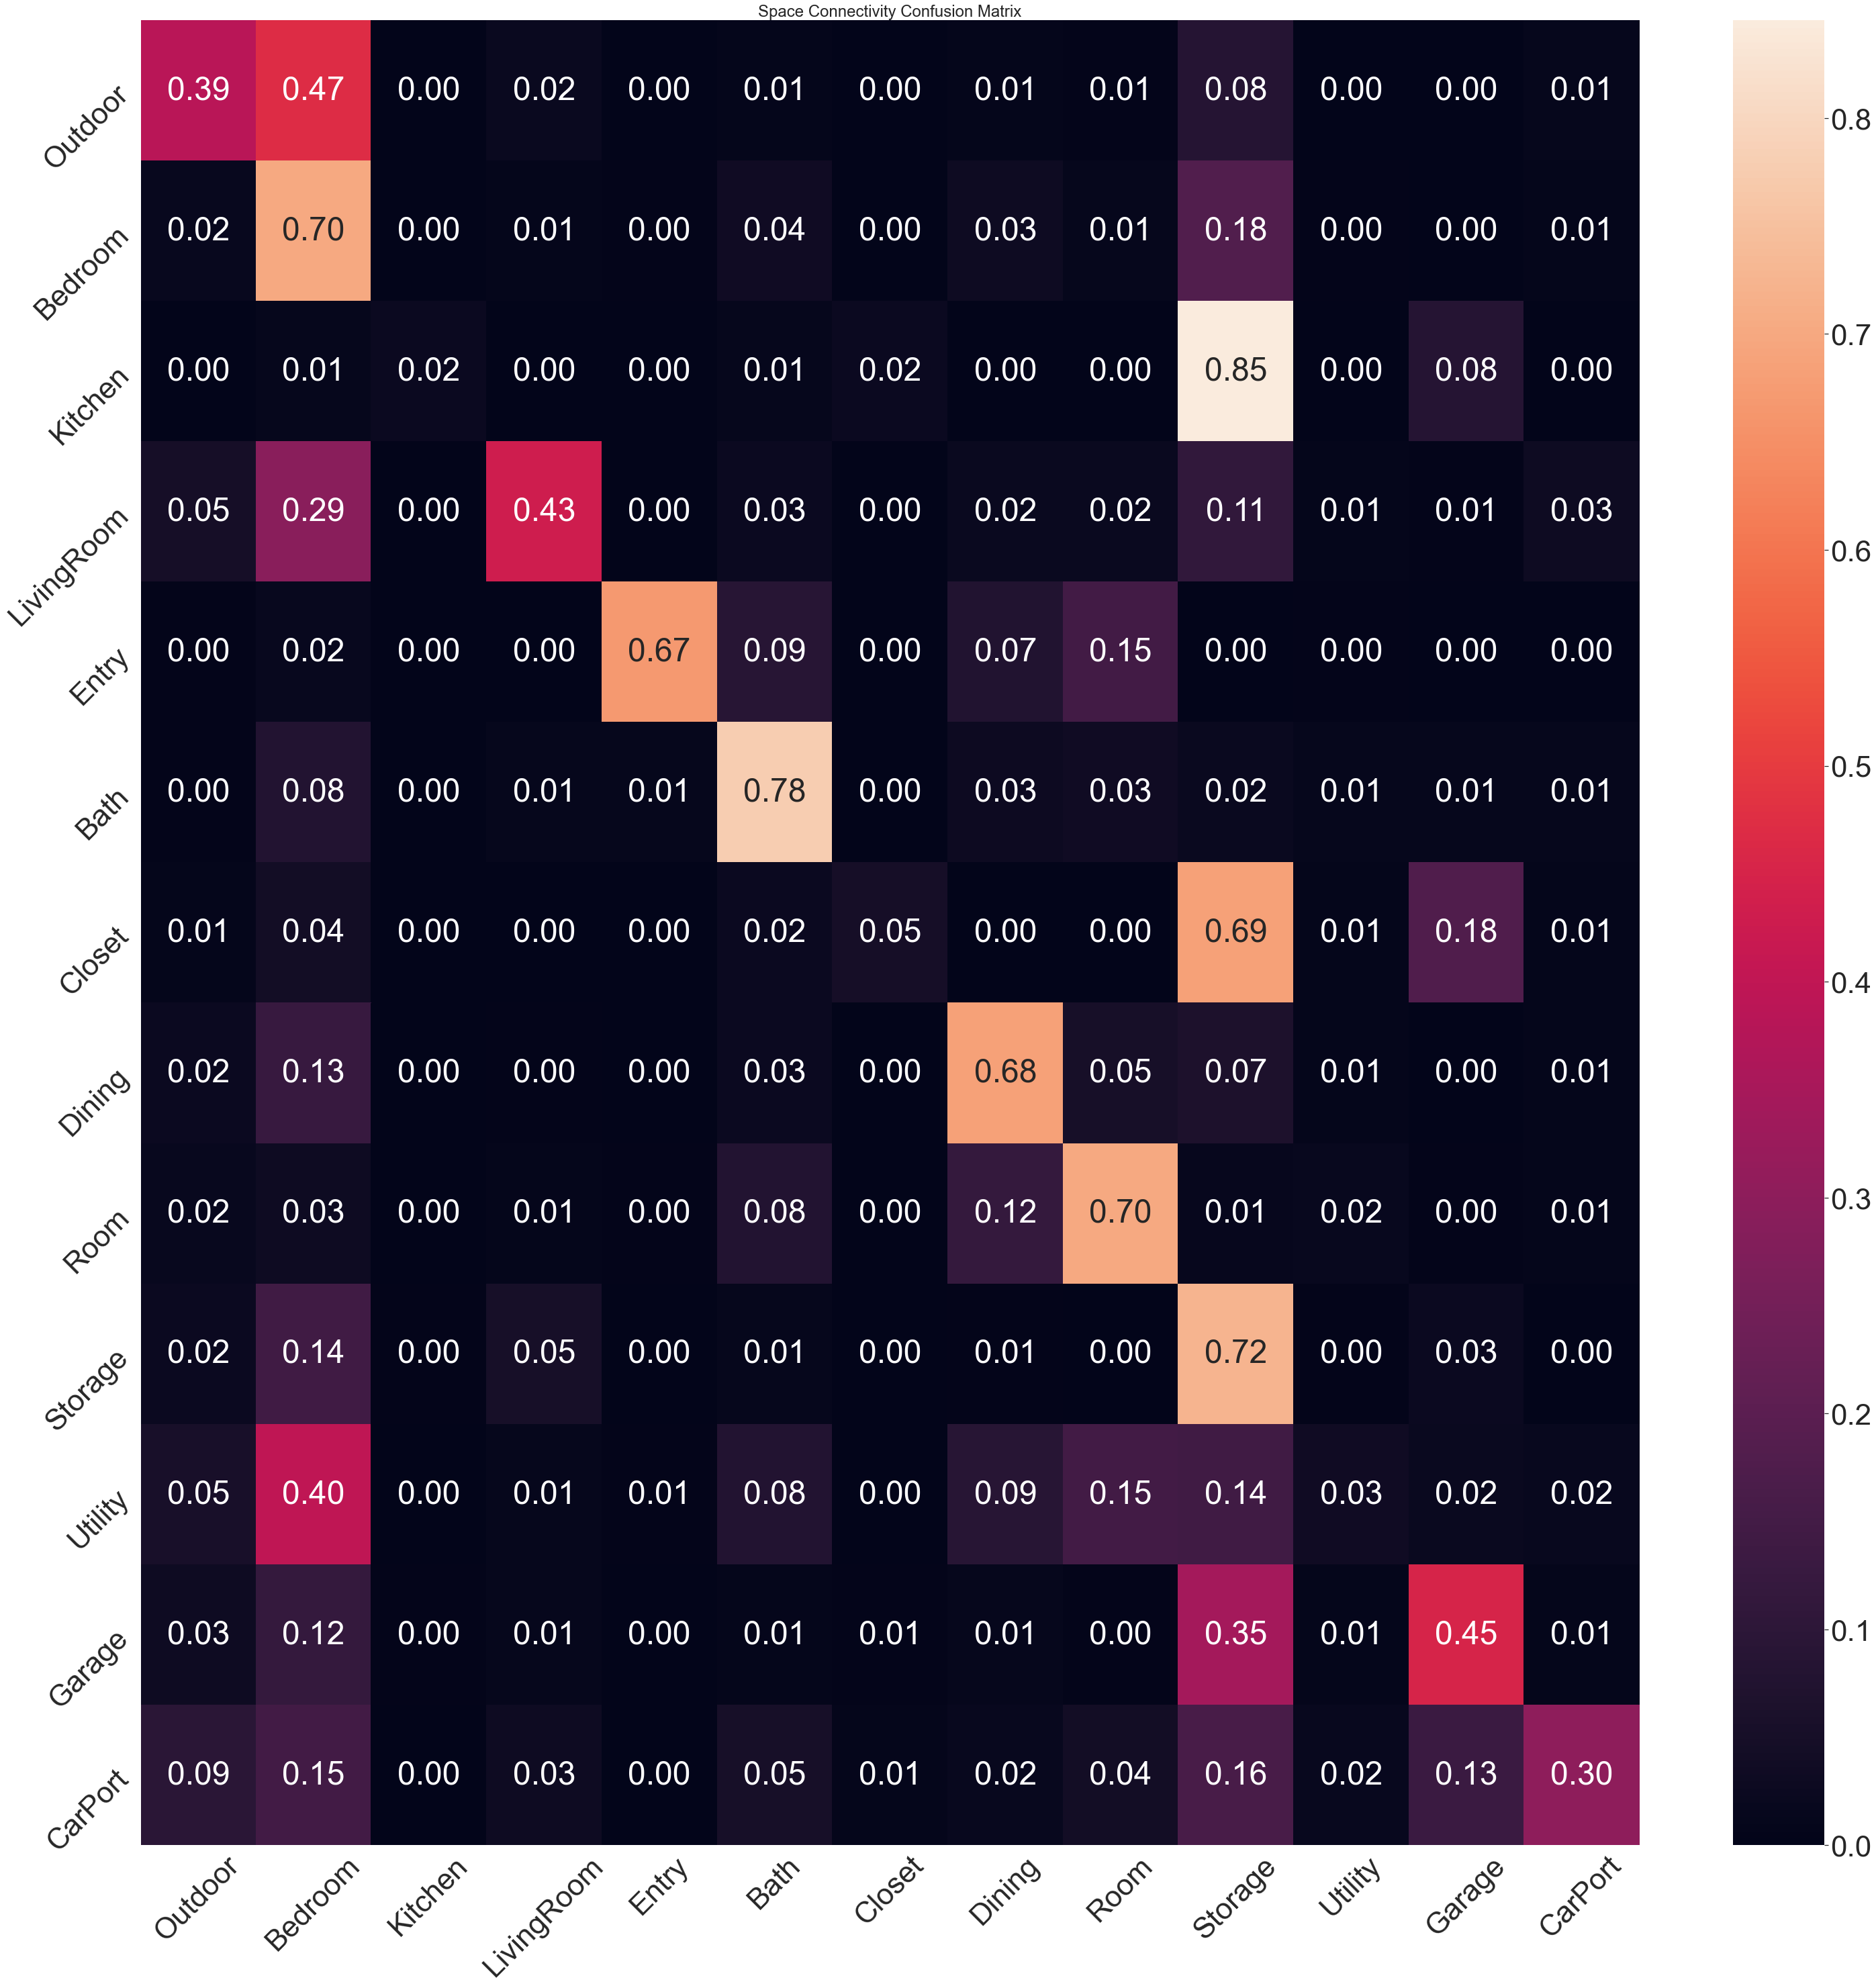

In [27]:
file_name = "RndmFrst_Tier1a_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_1a)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_1a).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Space Connectivity Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=300)
plt.show()

In [22]:
# # Feature importance
# shap_values = shap.TreeExplainer(model_1).shap_values(X_train_train)
# shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model_1.classes_, title='RandomForest Feature Importance', color = plt.get_cmap("tab20b"))
# plt.show()

## 1.b :Furniture Features

In [11]:
##TIER 1.b
#Train
X_train = X_train_train[[col for col in col_select['fur']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['fur']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['fur']]]
y_test = y_test_test['type_cleaned']

# Instanciate randomforest classifier 
model_1b = RandomForestClassifier(n_estimators= 400,
                                criterion='gini',
                                random_state= 27
                                )
print('Default Model')
print(model_1b.get_params())

# train model 
model_1b.fit(X_train,y_train)
#Mean accuracy of the data and its labels
train_score_1b = model_1b.score(X_train,y_train)
print("Furniture Features Training score: ",train_score_1b)

# predict
y_pred_1b = model_1b.predict(X_test)
# evaluate predictions
accuracy_1b = accuracy_score(y_test, y_pred_1b)
print("Accuracy: %.2f%%" % (accuracy_1b * 100.0))

# Report Classification Results
file_name = "RndmFrst_Tier1b_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_1b,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_1b))

Default Model
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
Furniture Features Training score:  0.5859588283036966
Accuracy: 56.74%
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
              precision    recall  f1-score   support

        Bath       0.97      0.92      0.94      2187
     Bedroom       0.57      0.47      0.52      2398
     CarPort       0.00      0.00      0.00        84
      Closet       0.34      0.34      0.34       912
      Dining       0.35      0.09      0.14       286
       Entry      

In [12]:
# file_name = "RndmFrst_Tier1b_ConfMat.png"
# fig_PATH = join(img_PATH,file_name)
# cMat = confusion_matrix(y_test,y_pred_1b)
# df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_1b).unique())
# plt.figure(figsize= (50,50))
# cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
# cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# plt.title('Furniture Features Confusion Matrix', fontsize = 24)
# sns.set(font_scale=4)
# plt.savefig(fig_PATH, dpi=300)
# plt.show()

## Space Properties

In [13]:
##TIER 1.b
#Train
X_train = X_train_train[[col for col in col_select['spc']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc']]]
y_test = y_test_test['type_cleaned']

# Instanciate randomforest classifier 
model_1c = RandomForestClassifier(n_estimators= 400,
                                criterion='gini',
                                random_state= 27
                                )
print('Default Model')
print(model_1c.get_params())

# train model 
model_1c.fit(X_train,y_train)
#Mean accuracy of the data and its labels
train_score_1c = model_1c.score(X_train,y_train)
print("Furniture Features Training score: ",train_score_1c)

# predict
y_pred_1c = model_1c.predict(X_test)
# evaluate predictions
accuracy_1c = accuracy_score(y_test, y_pred_1c)
print("Accuracy: %.2f%%" % (accuracy_1c * 100.0))

# Report Classification Results
file_name = "RndmFrst_Tier1c_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_1c,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_1c))

Default Model
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
Furniture Features Training score:  1.0
Accuracy: 80.62%
              precision    recall  f1-score   support

        Bath       0.79      0.84      0.81      2187
     Bedroom       0.77      0.91      0.83      2398
     CarPort       0.73      0.48      0.58        84
      Closet       0.63      0.62      0.63       912
      Dining       0.74      0.71      0.73       286
       Entry       0.86      0.92      0.89      1815
      Garage       0.63      0.68      0.65       124
     Kitchen       0.87      0.86      0.86      1364
  LivingRoom       0.78

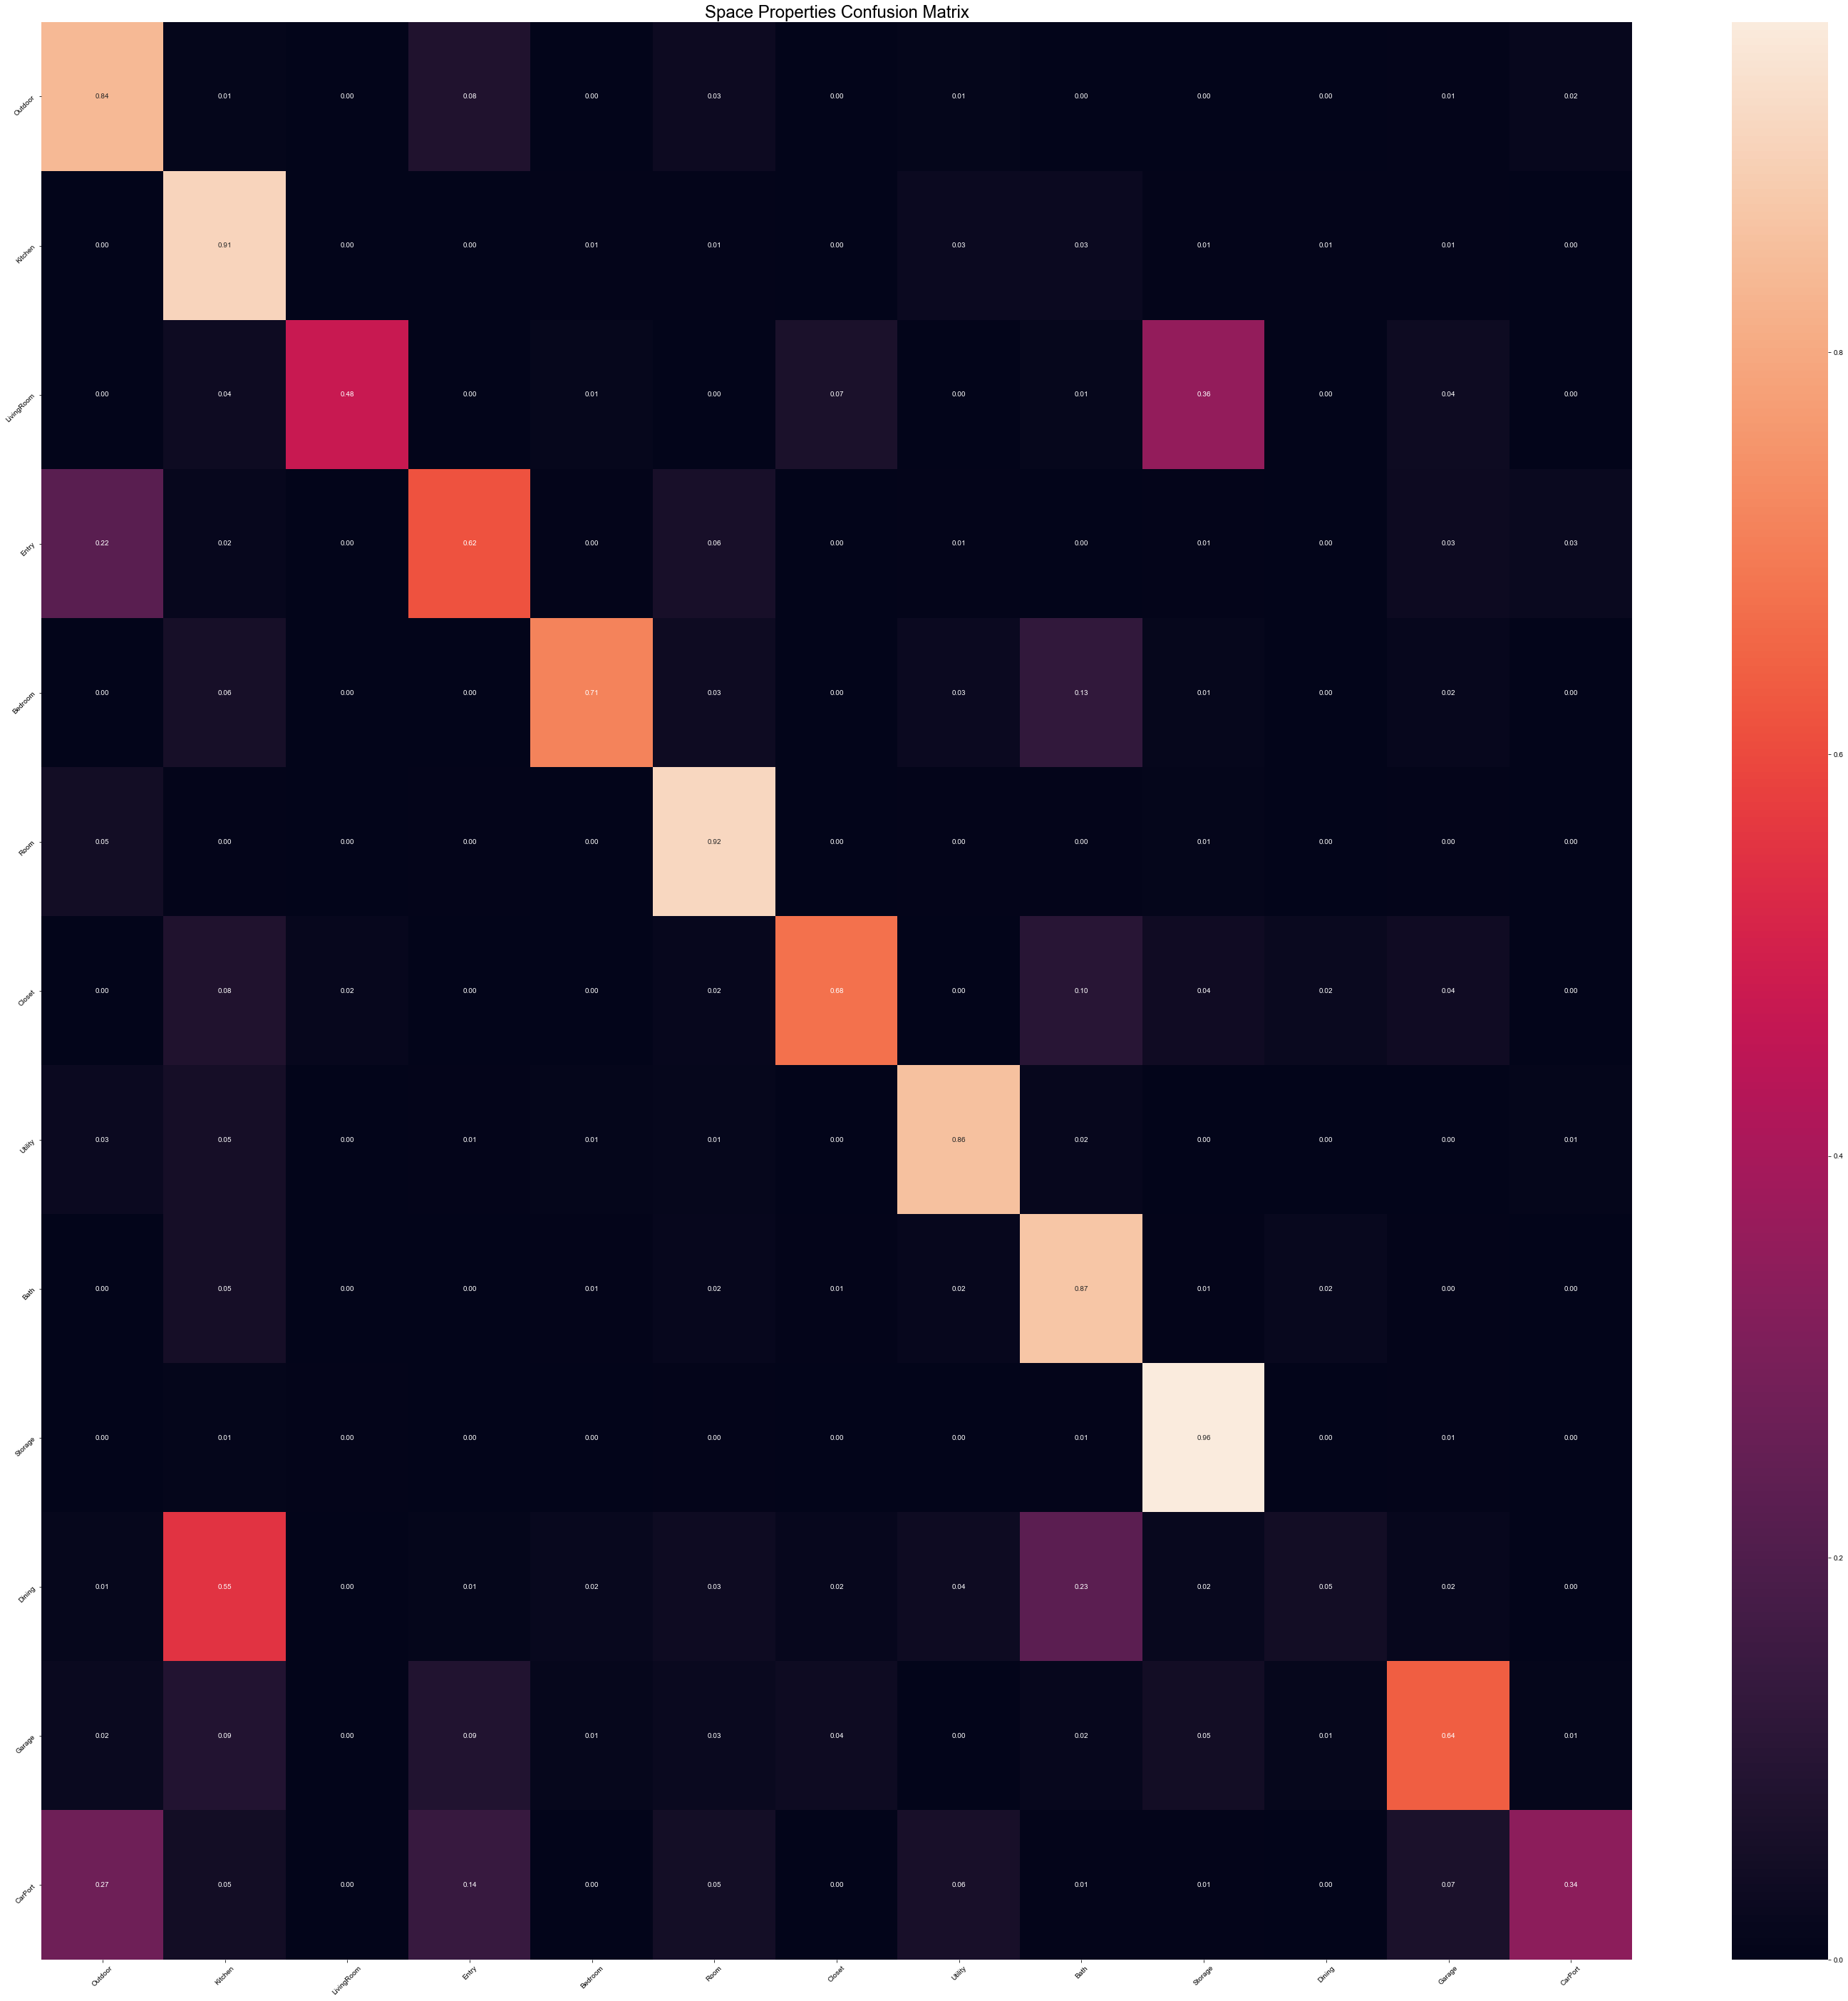

In [14]:
file_name = "RndmFrst_Tier1c_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_1c)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_1c).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Space Properties Confusion Matrix', fontsize = 24)
sns.set(font_scale=4)
plt.savefig(fig_PATH, dpi=300)
plt.show()

### Grid Search on Tier 1

In [15]:
param_grid = {'n_estimators': [200, 400,800],'class_weight':[None,"balanced","balanced_subsample"], 'oob_score': [None,False,True]} 
rfc_grid = RandomForestClassifier(criterion='gini',
                                  random_state= 27,
                                  verbose = 2,
                                  n_jobs = -1)
grid_search = GridSearchCV(rfc_grid, param_grid, cv=5 , scoring=['f1_macro','accuracy'] , return_train_score=True, refit='f1_macro')
grid_search.fit(X_train, y_train)

2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.2

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=27,
                                              verbose=2),
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'n_estimators': [200, 400, 800],
                         'oob_score': [None, False, True]},
             refit='f1_macro', return_train_score=True,
             scoring=['f1_macro', 'accuracy'])

In [16]:
cv_res = grid_search.cv_results_
# print (cv_res.keys())
for rank_f1,rank_acu,mean_f1_score,mean_acu_score, params in zip(cv_res['rank_test_f1_macro'],cv_res['rank_test_accuracy'], cv_res['mean_test_f1_macro'],cv_res['mean_test_accuracy'], cv_res['params']):
    print('Rank f1:',rank_f1,' Rank Accuracy:',rank_acu,' Mean f1_macro:',mean_f1_score,'Mean accuracy: ',mean_acu_score, params)
print('\n')
print("Best parameters:" , grid_search.best_params_)

Rank f1: 16  Rank Accuracy: 22  Mean f1_macro: 0.6929265680482138 Mean accuracy:  0.8072383644598098 {'class_weight': None, 'n_estimators': 200, 'oob_score': None}
Rank f1: 16  Rank Accuracy: 22  Mean f1_macro: 0.6929265680482138 Mean accuracy:  0.8072383644598098 {'class_weight': None, 'n_estimators': 200, 'oob_score': False}
Rank f1: 16  Rank Accuracy: 22  Mean f1_macro: 0.6929265680482138 Mean accuracy:  0.8072383644598098 {'class_weight': None, 'n_estimators': 200, 'oob_score': True}
Rank f1: 25  Rank Accuracy: 7  Mean f1_macro: 0.6917656380282117 Mean accuracy:  0.8076811076179489 {'class_weight': None, 'n_estimators': 400, 'oob_score': None}
Rank f1: 25  Rank Accuracy: 7  Mean f1_macro: 0.6917656380282117 Mean accuracy:  0.8076811076179489 {'class_weight': None, 'n_estimators': 400, 'oob_score': False}
Rank f1: 25  Rank Accuracy: 7  Mean f1_macro: 0.6917656380282117 Mean accuracy:  0.8076811076179489 {'class_weight': None, 'n_estimators': 400, 'oob_score': True}
Rank f1: 22  Rank

### Train based on grid search result

In [17]:
# Instanciate randomforest classifier 
bst_model = RandomForestClassifier(
                       bootstrap=True, class_weight="balanced", criterion='gini',
                       max_features='auto',
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, random_state=27,
                       verbose=1, warm_start=False)
# train model 
bst_model.fit(X_train,y_train)
# predict
bst_model_pred = bst_model.predict(X_test)
# Evaluate model
# print( confusion_matrix(y_test,rfc_pred))
print('\n')
print( classification_report(y_test,bst_model_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.9s finished


              precision    recall  f1-score   support

        Bath       0.79      0.84      0.81      2187
     Bedroom       0.76      0.91      0.83      2398
     CarPort       0.68      0.56      0.61        84
      Closet       0.63      0.62      0.62       912
      Dining       0.76      0.69      0.72       286
       Entry       0.87      0.91      0.89      1815
      Garage       0.65      0.65      0.65       124
     Kitchen     

## Tier 2

In [18]:
    # 'spc_con' : tier_2a,
    # 'spc_fur' : tier_2b 

## 2.a: Space Properties with Connectivity Features

In [19]:
##TIER 2.a
#Train
X_train = X_train_train[[col for col in col_select['spc_con']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc_con']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc_con']]]
y_test = y_test_test['type_cleaned']

# Instanciate randomforest classifier 
# Instanciate randomforest classifier 
bst_model_2a = RandomForestClassifier(
                       bootstrap=True, class_weight="balanced", criterion='gini',
                       max_features='auto',
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, random_state=27,
                       verbose=1, warm_start=False)
print('bst_model_2')
print(bst_model_2a.get_params())

# train model 
bst_model_2a.fit(X_train,y_train)
#Mean accuracy of the data and its labels
train_score_2a = bst_model_2a.score(X_train,y_train)
print("Space Pro. and Connectivity Features Training score: ",train_score_2a)

# predict
y_pred_2a = bst_model_2a.predict(X_test)
# evaluate predictions
accuracy_2a = accuracy_score(y_test, y_pred_2a)
print("Accuracy: %.2f%%" % (accuracy_2a * 100.0))

# Report Classification Results
file_name = "RndmFrst_Tier2a_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_2a,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_2a))

bst_model_2
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 27, 'verbose': 1, 'warm_start': False}
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    1.1s finished
[Parallel(n_jobs=

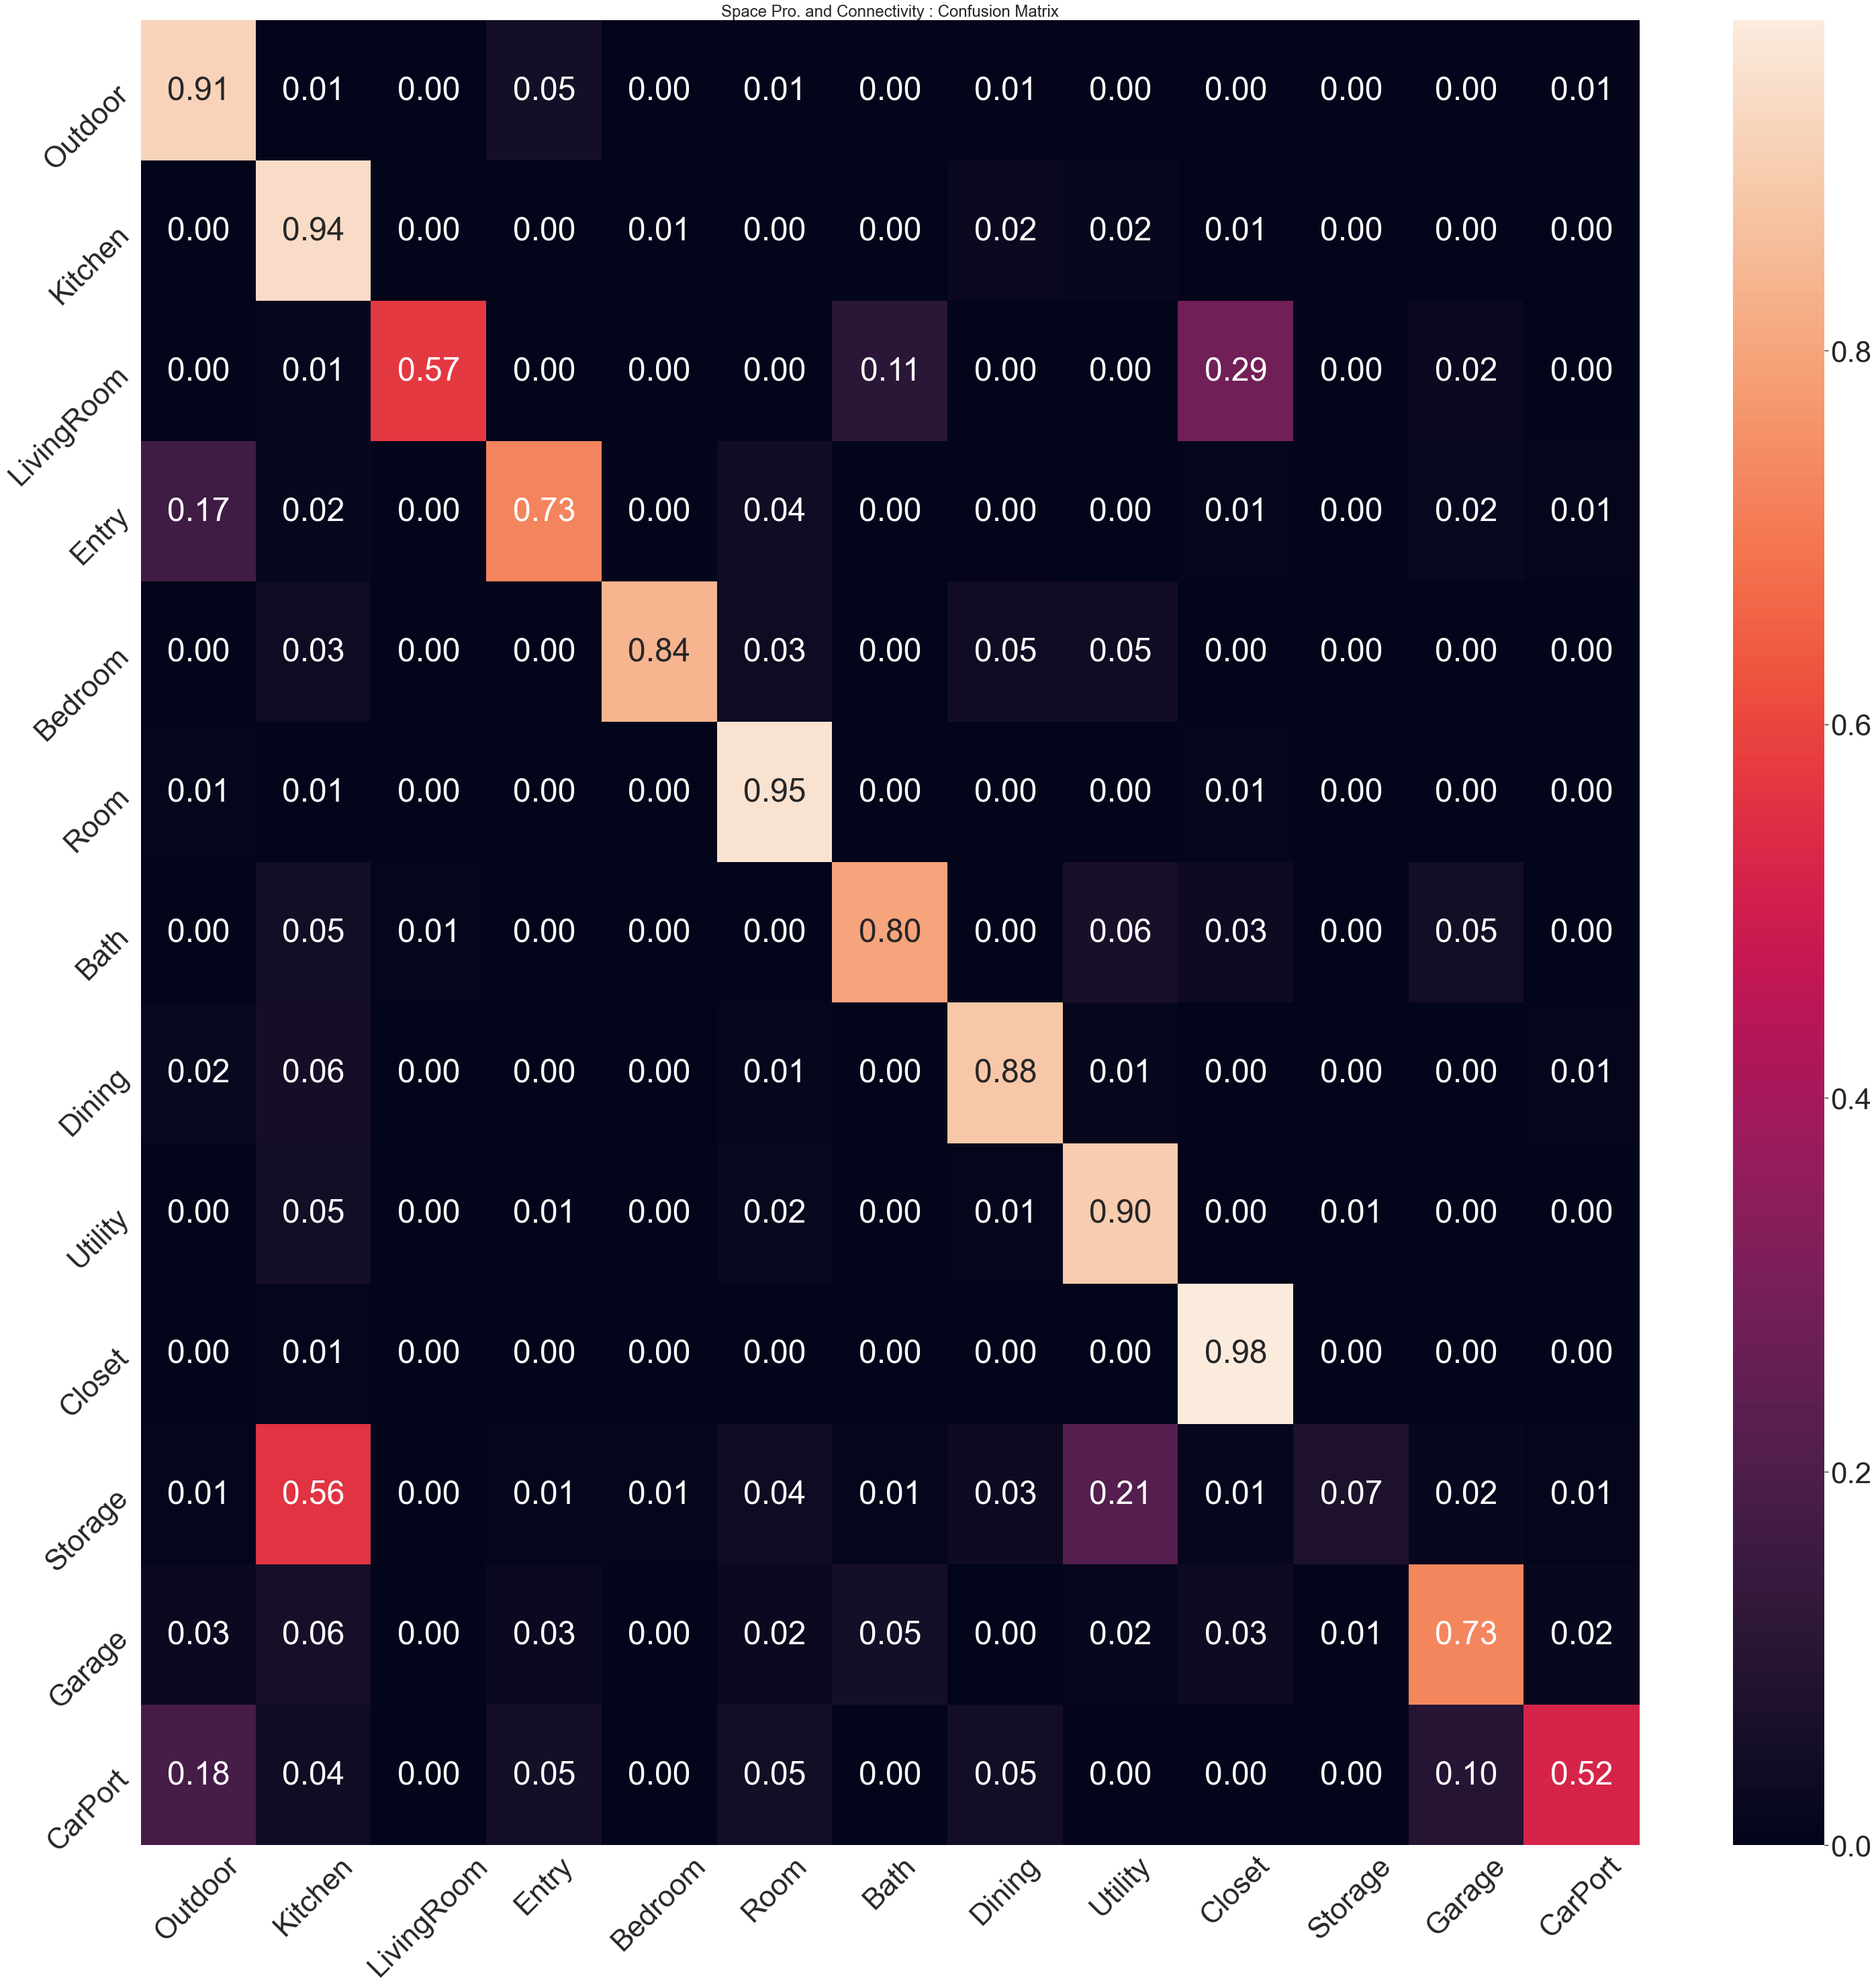

In [20]:
file_name = "RndmFrst_Tier2a_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_2a)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_2a).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Space Pro. and Connectivity : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=300)
plt.show()

## Space Properties with Furniture Features

In [25]:
##TIER 2.b
#Train
X_train = X_train_train[[col for col in col_select['spc_fur']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc_fur']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc_fur']]]
y_test = y_test_test['type_cleaned']

# Instanciate randomforest classifier 
# Instanciate randomforest classifier 
bst_model_2b = RandomForestClassifier(
                       bootstrap=True, class_weight="balanced", criterion='gini',
                       max_features='auto',
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, random_state=27,
                       verbose=1, warm_start=False)
print('bst_model_2b')
print(bst_model_2b.get_params())

# train model 
bst_model_2b.fit(X_train,y_train)
#Mean accuracy of the data and its labels
train_score_2b = bst_model_2b.score(X_train,y_train)
print("Space Pro. and Connectivity Features Training score: ",train_score_2b)

# predict
y_pred_2b = bst_model_2b.predict(X_test)
# evaluate predictions
accuracy_2b = accuracy_score(y_test, y_pred_2b)
print("Accuracy: %.2f%%" % (accuracy_2b * 100.0))

# Report Classification Results
file_name = "RndmFrst_Tier2b_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_2b,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_2b))

bst_model_2b
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 27, 'verbose': 1, 'warm_start': False}
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs

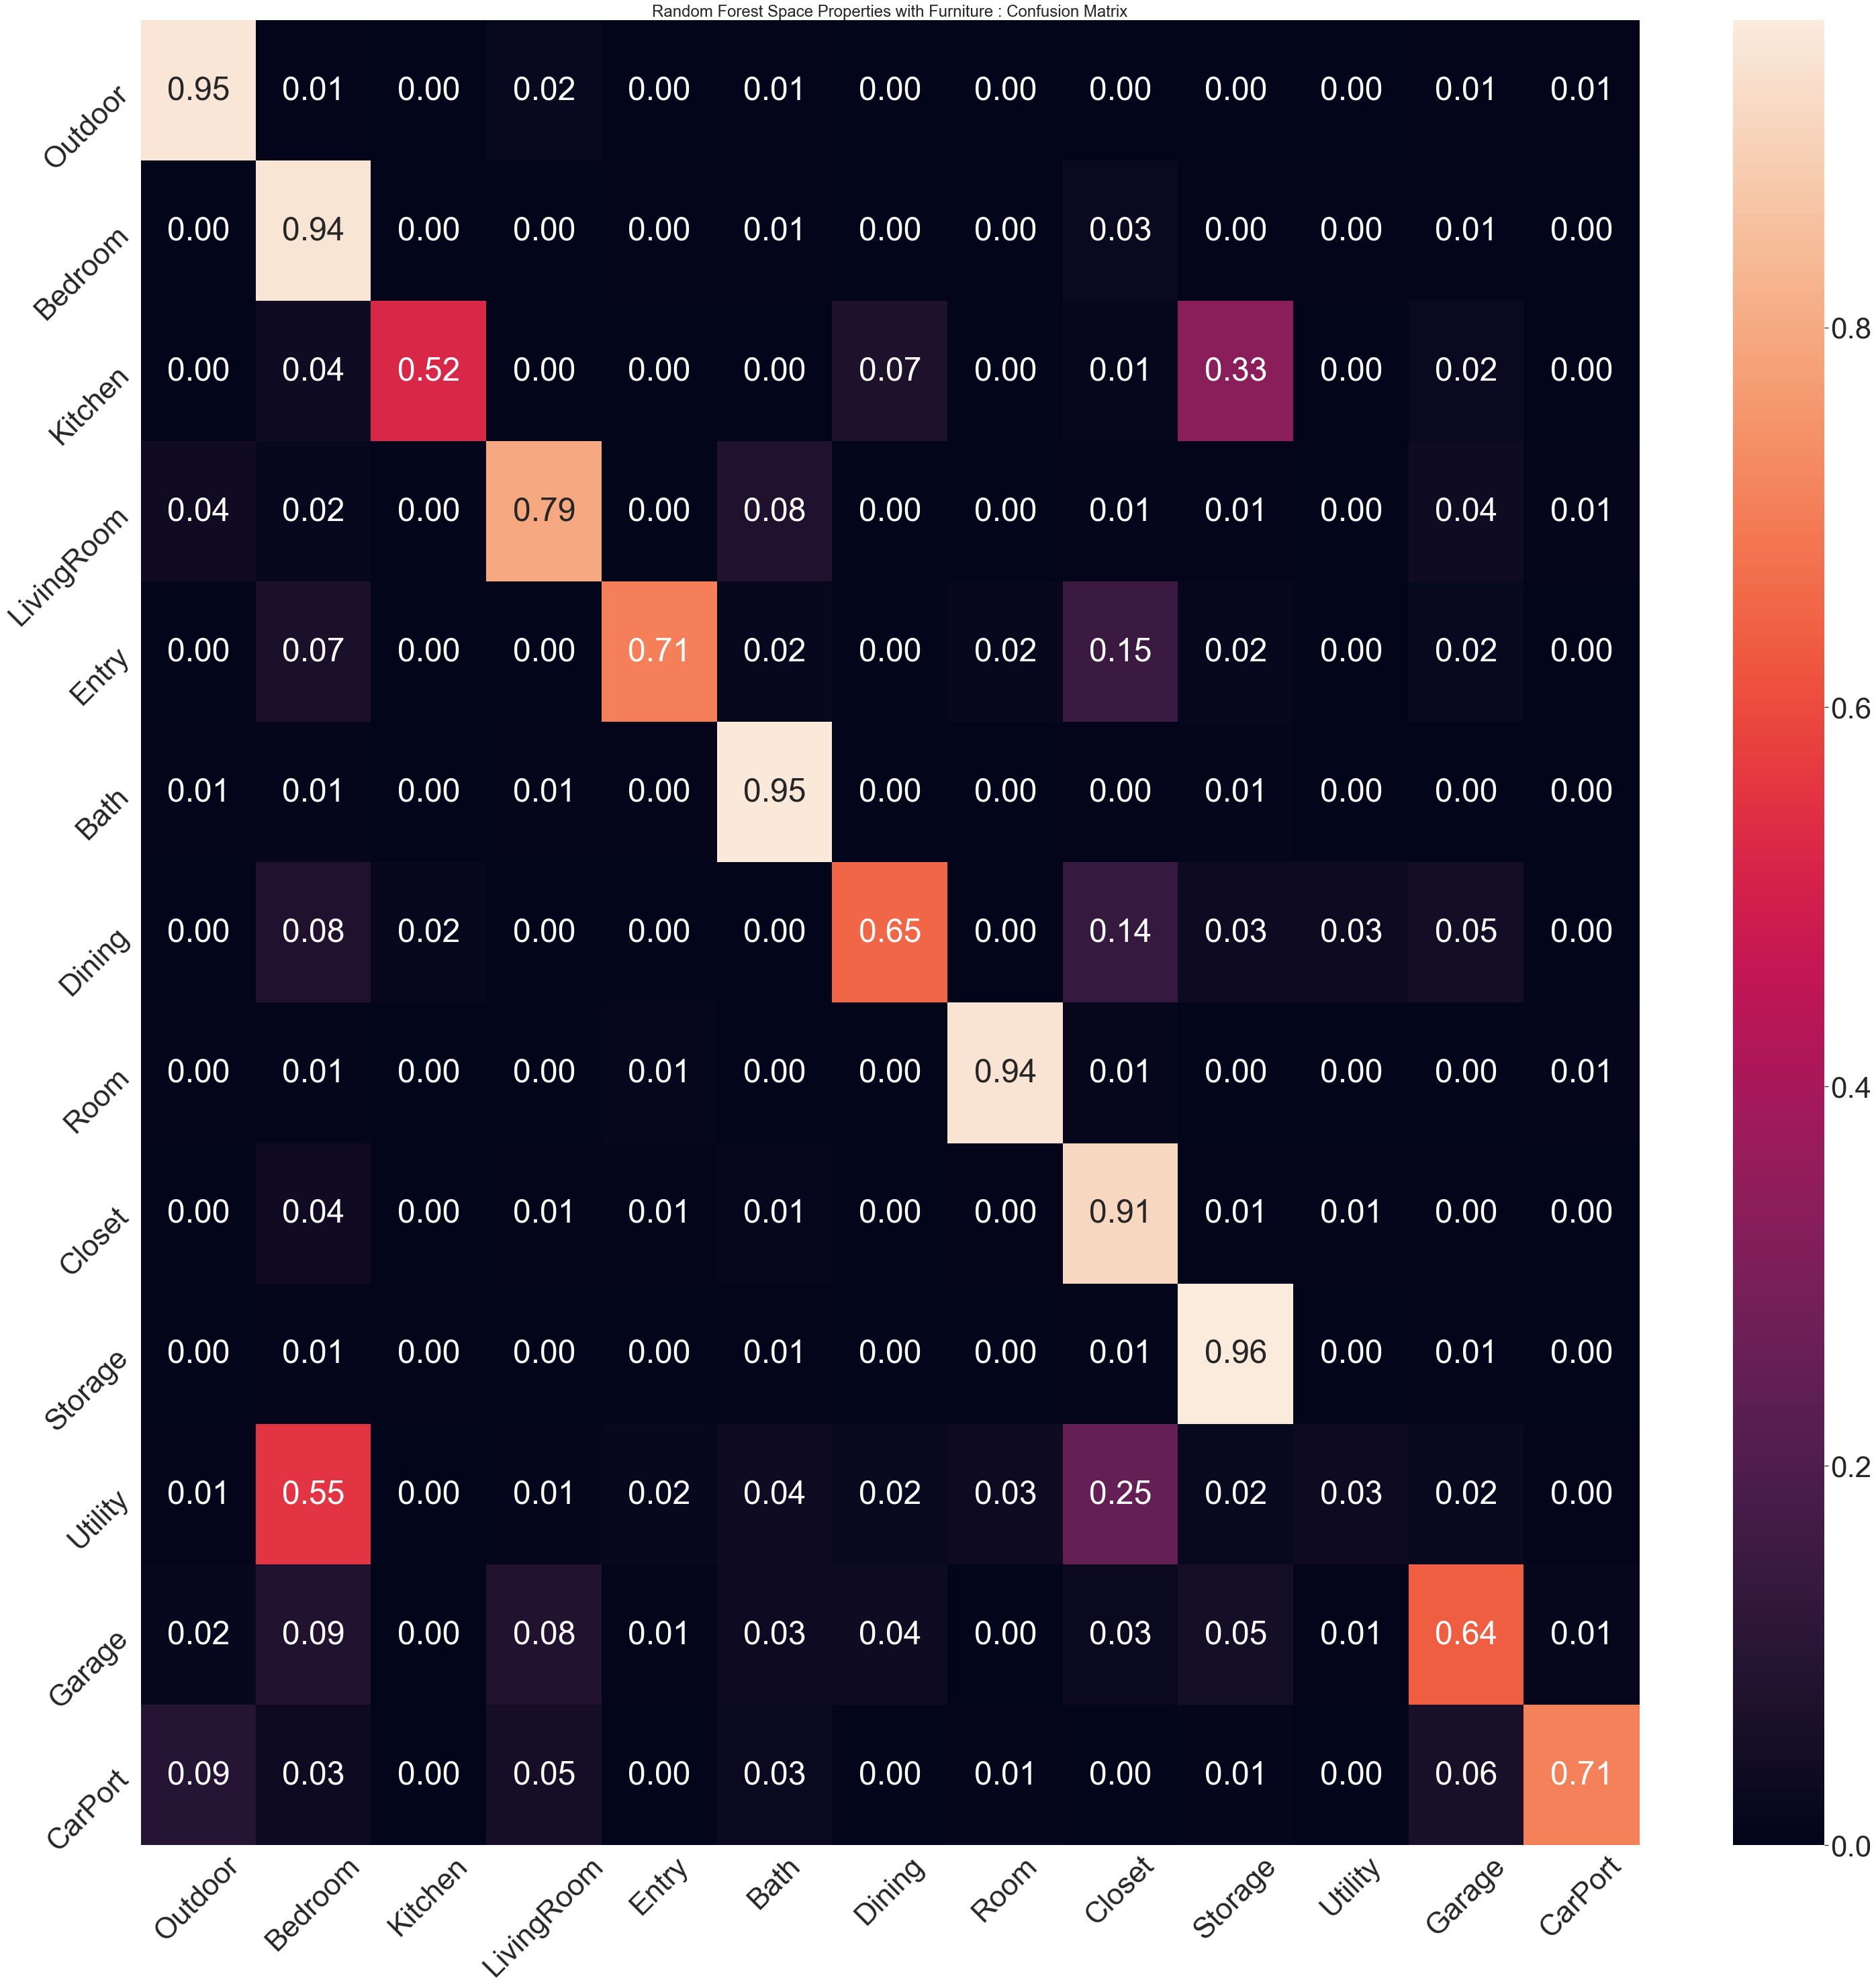

In [26]:
file_name = "RndmFrst_Tier2B_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_2b)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_2b).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Random Forest Space Properties with Furniture : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=300)
plt.show()

## Tier 3

In [21]:
##TIER 3
#Train
X_train = X_train_train
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test
y_test = y_test_test['type_cleaned']

# Instanciate randomforest classifier 
# Instanciate randomforest classifier 
bst_model_3 = RandomForestClassifier(
                       bootstrap=True, class_weight="balanced", criterion='gini',
                       max_features='auto',
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, random_state=27,
                       verbose=1, warm_start=False)
print('bst_model_3')
print(bst_model_3.get_params())

# train model 
bst_model_3.fit(X_train,y_train)
#Mean accuracy of the data and its labels
train_score_3 = bst_model_3.score(X_train,y_train)
print("All Features Training score: ",train_score_3)

# predict
y_pred_3 = bst_model_3.predict(X_test)
# evaluate predictions
accuracy_3 = accuracy_score(y_test, y_pred_3)
print("Accuracy: %.2f%%" % (accuracy_3 * 100.0))

# Report Classification Results
file_name = "RndmFrst_Tier3_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_3,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_3))

bst_model_3
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'oob_score': False, 'random_state': 27, 'verbose': 1, 'warm_start': False}
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    1.1s finished
[Parallel(n_jobs=

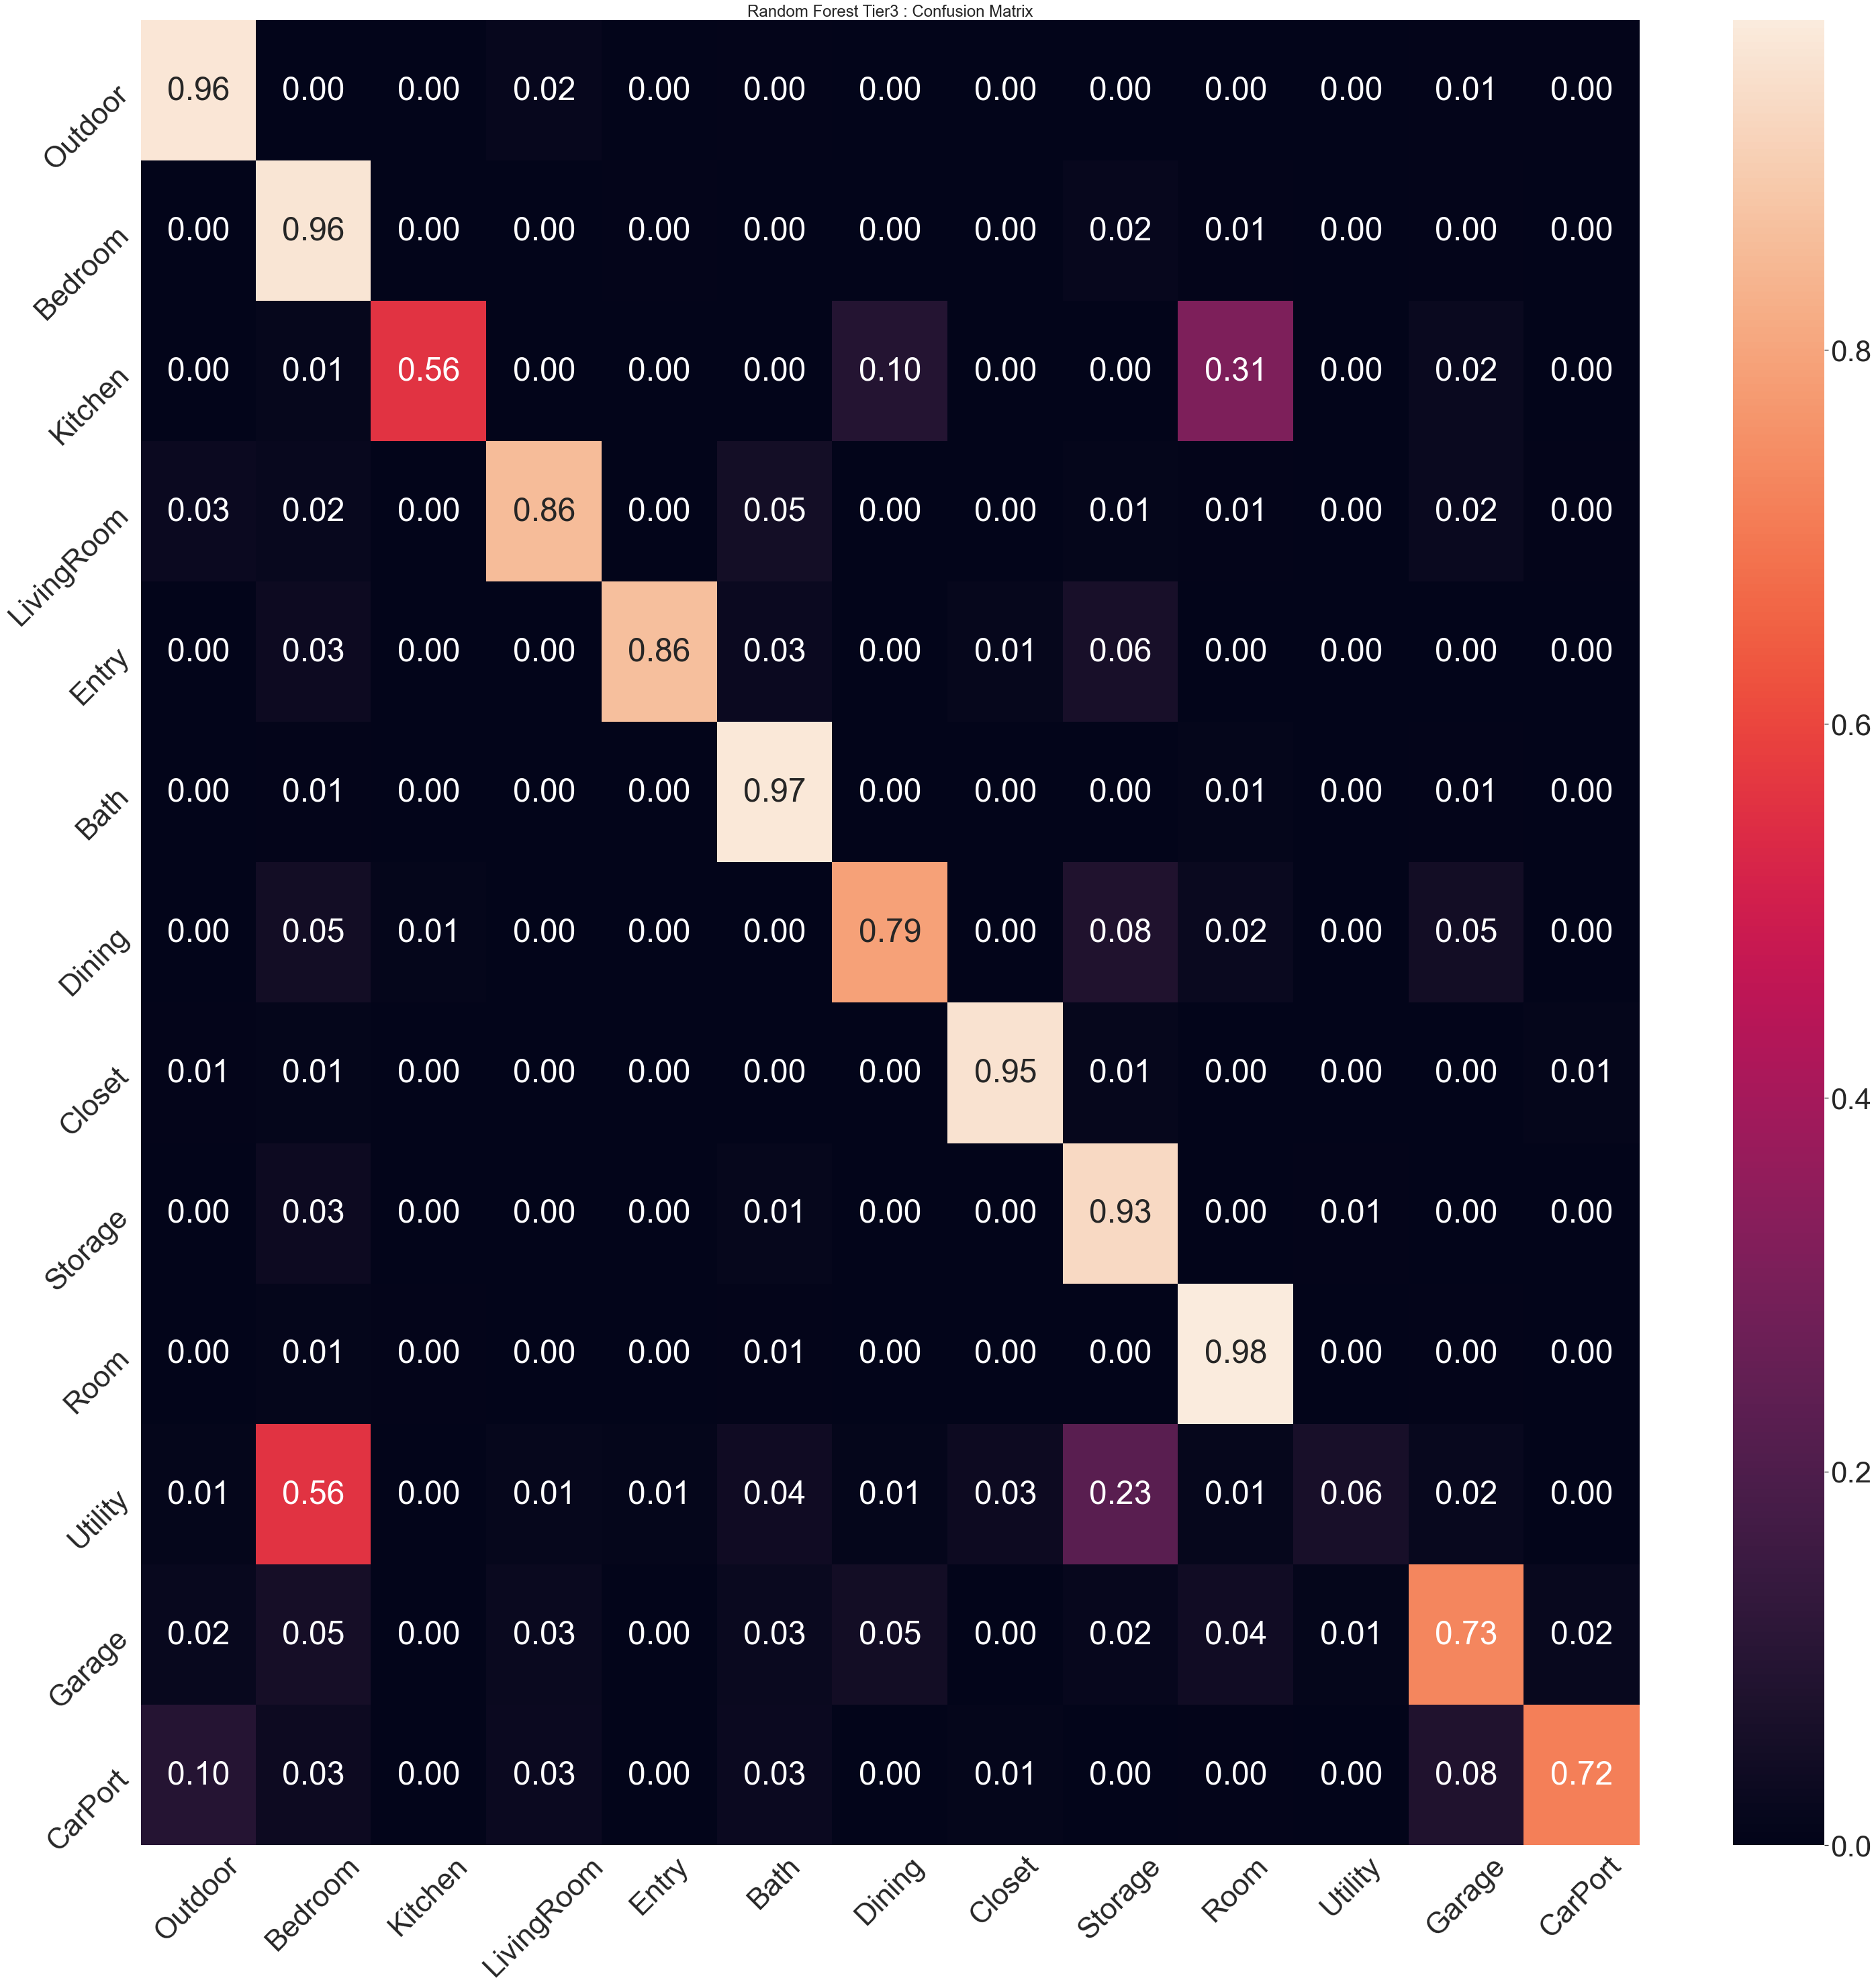

In [23]:
file_name = "RndmFrst_Tier3_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_3)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_3).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
sns.set(font_scale=4)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('Random Forest Tier3 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=300)
plt.show()

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


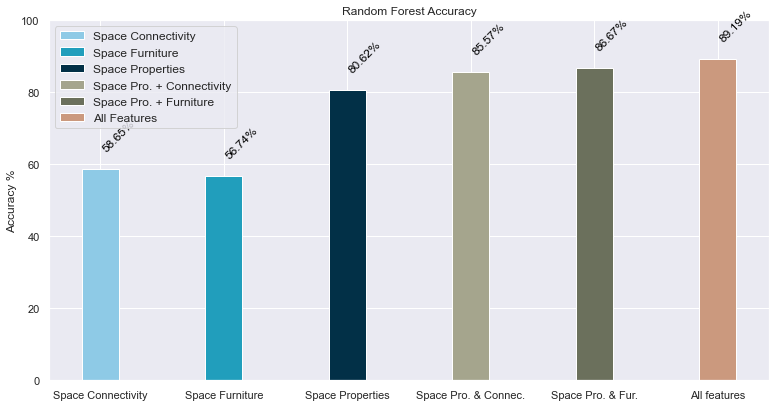

In [31]:
## Accuracy Comparison
sns.set(font_scale=1)
file_name = "RndmFrst_acu.png"
fig_PATH = join(img_PATH,file_name)
fig_acu = plt.figure(figsize=(10,5))
ax_acu = fig_acu.add_axes([0.1,0.1,1,1])
ax_acu.bar(x='Space Connectivity', height = accuracy_1a*100,width=0.3, label='Space Connectivity', color='#8ecae6')
ax_acu.bar(x='Space Furniture', height = accuracy_1b*100,width=0.3, label='Space Furniture', color='#219ebc')
ax_acu.bar(x='Space Properties', height = accuracy_1c*100,width=0.3, label='Space Properties', color='#023047')
ax_acu.bar(x='Space Pro. & Connec.', height = accuracy_2a*100,width=0.3, label='Space Pro. + Connectivity', color='#a5a58d')
ax_acu.bar(x='Space Pro. & Fur.', height = accuracy_2b*100,width=0.3, label='Space Pro. + Furniture', color='#6b705c')
ax_acu.bar(x='All features', height = accuracy_3*100,width=0.3, label='All Features', color='#cb997e')
# Values
ax_acu.set_title('Random Forest Accuracy', fontsize=12)
ax_acu.set_ylim(0,100)
ax_acu.legend(loc=2, fontsize=12)
ax_acu.set_ylabel('Accuracy %', fontsize=12)
ax_acu.text('Space Connectivity', accuracy_1a*100+5, "%.2f%%" % (accuracy_1a * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('Space Furniture', accuracy_1b*100+5, "%.2f%%" % (accuracy_1b * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('Space Properties', accuracy_1c*100+5, "%.2f%%" % (accuracy_1c * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('Space Pro. & Connec.', accuracy_2a*100+5, "%.2f%%" % (accuracy_2a * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('Space Pro. & Fur.', accuracy_2b*100+5, "%.2f%%" % (accuracy_2b * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('All features', accuracy_3*100+5, "%.2f%%" % (accuracy_3 * 100.0), color='black', rotation=45, fontsize=12)
fig_acu.tight_layout()
fig_acu.savefig(fig_PATH,dpi=300)